# Grand Tour 

- Rules: Draw a single closed loop in the grid which visits all grid dots exactly once and uses all given line segments

> To be converted to SCIP Solver...

In [ ]:
import os
import sys
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb # for Gurobi solver
import numpy as np 
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle

from pyscipopt import Model, quicksum # for scip solver
sys.path.append("..") 
from Utils.grid_utils import vertex_to_arcs


# Defining the function to map decimal input to the corresponding sides being blackened
def blackened_sides(decimal_number):

    sides = ["T","L","B", "R"]
    # Convert the decimal number to 4-bit binary, padded with zeros if necessary
    binary_representation = format(decimal_number, '04b')
    blackened = [sides[i] for i in range(4) if binary_representation[i] == '1']
    return blackened

# Test the function with the input 7
if __name__ == "__main__":
    blackened_sides(7)


In [ ]:
def readInstance(path):
    
    # file_name = f"../assets/data/GrandTourSolverdata/{path}{np.random.randint(1)+1}.txt"
    file_name = f"../assets/data/GrandTour/problems/{path}"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[0 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                for j in range(n):
                    if line[j] not in ['-']:
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    data = "16_11x11.txt"
    m, n, grids = readInstance(data)
    print(m,n)
    # print(grids)
    for row in grids:
        print(row)

READING FILE ../assets/data/GrandTour/problems/16_11x11.txt
11 11
[0, 0, 2, 2, 8, 0, 2, 2, 8, 0, 0]
[0, 1, 12, 8, 0, 1, 14, 8, 0, 1, 6]
[0, 2, 0, 2, 0, 2, 8, 2, 0, 0, 8]
[2, 8, 2, 8, 0, 8, 2, 8, 0, 0, 2]
[10, 2, 8, 2, 0, 0, 10, 0, 1, 4, 8]
[8, 8, 0, 8, 2, 1, 12, 0, 1, 4, 0]
[2, 0, 0, 2, 8, 2, 0, 0, 1, 4, 2]
[8, 0, 2, 8, 0, 8, 0, 2, 0, 0, 8]
[2, 0, 8, 3, 4, 0, 0, 9, 4, 0, 0]
[8, 0, 1, 12, 1, 4, 0, 2, 1, 4, 0]
[0, 0, 0, 0, 1, 4, 0, 9, 4, 0, 0]


## SCIP solver 

In [ ]:


def GrandTourSolverWithSCIP(m, n, grids):
    model = Model("GrandTourSCIP")
    model.setMinimize()  # 设置目标为最小化

    x = {}
    node_nums = (m + 1) * (n + 1)
    node2Arc = {}
    all_arcs = []
    for i in range(m + 1):
        for j in range(n + 1):
            if i != m and j != n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {i * (n + 1) + j + 1}]"
                )
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {(i + 1) * (n + 1) + j}]"
                )
                all_arcs.append((i * (n + 1) + j, i * (n + 1) + j + 1))
                all_arcs.append((i * (n + 1) + j, (i + 1) * (n + 1) + j))
            elif i == m and j != n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {i * (n + 1) + j + 1}]"
                )
                all_arcs.append((i * (n + 1) + j, i * (n + 1) + j + 1))
            elif i != m and j == n:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i * (n + 1) + j}, {(i + 1) * (n + 1) + j}]"
                )
                all_arcs.append((i * (n + 1) + j, (i + 1) * (n + 1) + j))
            node2Arc[i, j] = vertex_to_arcs(m, n, i, j)
            x[i, j, 0] = model.addVar(
                    vtype = "B", 
                    name = f"x[{i}, {j}, 0]"
                )

    for i in range(m + 1):
        for j in range(n + 1):
            model.addCons(quicksum(x[a, b] for (a, b) in node2Arc[i, j]) == 2 * x[i, j, 0], name = f"Balance_{i}_{j}")
    
    model.setObjective(quicksum(x[a, b] for (a, b) in all_arcs), "minimize")
    model.hideOutput()

    # 添加黑边约束
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 0:
                continue
            edges = blackened_sides(grids[i][j])  # 假设blackened_sides函数已定义
            for edge in edges:
                # 计算对应边
                if edge == 'L':
                    u = i * (n + 1) + j
                    v = (i + 1) * (n + 1) + j
                    model.addCons(x[u, v] == 1, name=f"L_{i}_{j}")
                elif edge == "R":
                    u = i * (n + 1) + j + 1
                    v = (i + 1) * (n + 1) + j + 1
                    model.addCons(x[u, v] == 1, name=f"R_{i}_{j}")
                elif edge == "B":
                    u = (i + 1) * (n + 1) + j
                    v = (i + 1) * (n + 1) + j + 1
                    model.addCons(x[u, v] == 1, name=f"B_{i}_{j}")
                elif edge == "T":
                    u = i * (n + 1) + j
                    v = i * (n + 1) + j + 1
                    model.addCons(x[u, v] == 1, name=f"T_{i}_{j}")

    def addCut(edges):
        G = nx.Graph()
        G.add_edges_from(edges)
        components = list( list(c) for c in nx.connected_components(G))
        # print(f"Totally: {len(components)} subtours!")
        if len(components) == 1:
            return False
        else:
            # cutting_edges = []
            for component in components:
                prev = -1
                curr = component[0]
                cntt = len(component)
                nodeSet = set(component)
                temp = list()
                while cntt > 0:
                    for direct in [- n - 1, n + 1, -1, 1]:
                        target = direct + curr 
                        curredge = (curr, target) if curr < target else (target, curr)
                        if target in nodeSet and target != prev and curredge in edges:
                            temp.append(curredge)
                            prev = curr 
                            curr = target 
                            break 
                    cntt -= 1
                model.freeTransform()
                model.addCons(quicksum(x[a, b] for (a, b) in temp) <= len(temp) - 1)
                # print("Add Cut!")
            return True

    # model.setPresolve(0)  # 禁用presolve以兼容可能的分支切割策略
    arcs = []
    while True:
        model.optimize()
        edges = []
        for cur_key in x.keys():
            if len(cur_key) < 3:
                a, b = cur_key[0], cur_key[1]
                if model.getVal( x[a, b]) > 1e-1:
                    edges.append((a, b))
        if not addCut(edges):
            print(f"Model Status: {model.getStatus()}")
            print(f"Total arcs: {model.getObjVal()}")
            sol = model.getBestSol()
            for (a, b) in all_arcs:
                if sol[x[a, b]] > 1e-1:
                    arcs.append([a, b])
            break

    return result

if __name__ == "__main__":
    result = GrandTourSolverWithSCIP(m, n, grids)
    print(result)



/var/folders/wp/zfkgqzvj2lq6fk2gy0rbmq6m0000gn/T/ipykernel_51290/933505490.py:4: UserWarning: linked SCIP 9.02 is not recommended for this version of PySCIPOpt - use version 9.2.1
  model = Model("GrandTourSCIP")


Model Status: optimal
Total arcs: 94.0
{'TotalCost': 144.0, 'runtime': 0.024997949600219727, 'arcs': [[0, 1], [0, 12], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 23], [12, 13], [13, 25], [14, 15], [14, 26], [15, 16], [16, 17], [17, 29], [18, 19], [18, 30], [19, 20], [20, 21], [21, 33], [22, 23], [22, 34], [24, 25], [24, 36], [26, 38], [27, 28], [27, 39], [28, 29], [30, 31], [31, 32], [32, 44], [33, 45], [34, 35], [35, 47], [36, 37], [37, 38], [39, 40], [40, 52], [41, 42], [41, 53], [42, 43], [43, 44], [45, 57], [46, 47], [46, 58], [48, 49], [48, 60], [49, 50], [50, 51], [51, 52], [53, 54], [54, 55], [55, 56], [56, 68], [57, 69], [58, 59], [59, 71], [60, 61], [61, 62], [62, 63], [63, 64], [64, 65], [65, 77], [66, 67], [66, 78], [67, 68], [69, 81], [70, 71], [70, 82], [72, 73], [72, 84], [73, 74], [74, 75], [75, 76], [76, 77], [78, 79], [79, 80], [80, 92], [81, 93], [82, 83], [83, 95], [84, 85], [85, 97], [86, 87], [86, 98], [87, 88], [88, 89]

## Gurobi solver

In [23]:
def GrandTourWithLazyCuts(m, n, grids):
    GrandTourSolver = grb.Model("GrandTour")
    x = dict()
    to_dict = dict()
    node_nums = (m + 1) * (n + 1)
    for i in range(m + 1):
        for j in range(n + 1):
            if j + 1 <= n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1) + j},{i * (n + 1) + j + 1}]"
                )
            if i < m:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1)},{(i + 1) * (n + 1)}]"
                )
                
    GrandTourSolver.modelSense = grb.GRB.MINIMIZE
    GrandTourSolver.Params.lazyConstraints = 1
    GrandTourSolver.update()
    
    for (ori, dep) in x.keys():
        if ori not in to_dict:
            to_dict[ori] = [[ori, dep]]
        else:
            to_dict[ori].append([ori, dep])
        if dep not in to_dict:
            to_dict[dep] = [[ori, dep]]
        else:
            to_dict[dep].append([ori, dep])
    
    for i in range(node_nums):
        GrandTourSolver.addConstr(grb.quicksum(x[i, j] for (i, j) in to_dict[i]) == 2, name = f"BALANCE_{i}")
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 0:
                continue
            edges = blackened_sides(grids[i][j])
            for edge in edges:
                if edge == 'L':
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, (i + 1) * (n + 1) + j] == 1, name = f"L_{i}_{j}")
                if edge == "R":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j + 1, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"R_{i}_{j}")
                if edge == "B":
                    GrandTourSolver.addConstr(x[(i + 1) * (n + 1) + j, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"B_{i}_{j}")
                if edge == "T":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, i * (n + 1) + j + 1 ] == 1, name = f"T_{i}_{j}")
                    
    def subtourelim(model, where):
        # 回调函数
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            # 获得当前图里所有的子环路
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # 消除那些环路
                    print("Add cut")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component \
                        for j in component if (i, j) in x.keys()) <= len(component) - 1)
                    
    GrandTourSolver._x = x
    GrandTourSolver.optimize(subtourelim)
    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (GrandTourSolver.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = GrandTourSolver.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        gap = 0
        lb = ofv
        ub = ofv
        runtime = GrandTourSolver.Runtime
    elif (GrandTourSolver.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = GrandTourSolver.MIPGap
        lb = GrandTourSolver.ObjBoundC
        ub = GrandTourSolver.ObjVal
        runtime = GrandTourSolver.Runtime


    
    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }

if __name__ == "__main__":
    result = GrandTourWithLazyCuts(m, n, grids)
    print(result)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-29
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 230 rows, 264 columns and 614 nonzeros
Model fingerprint: 0x491a8935
Variable types: 0 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 183 rows and 175 columns
Presolve time: 0.00s
Presolved: 47 rows, 89 columns, 176 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
The length is 6
Add cut
Add cut
Add cut
Add cut
Add cut
Add cut

Root relaxation: objective 1.440000e+02, 60 iterations, 0.00 seconds (0.00 work units)
The length is 8
Add cut
Add cut
Add cut
Add cut
Add cut
Add 

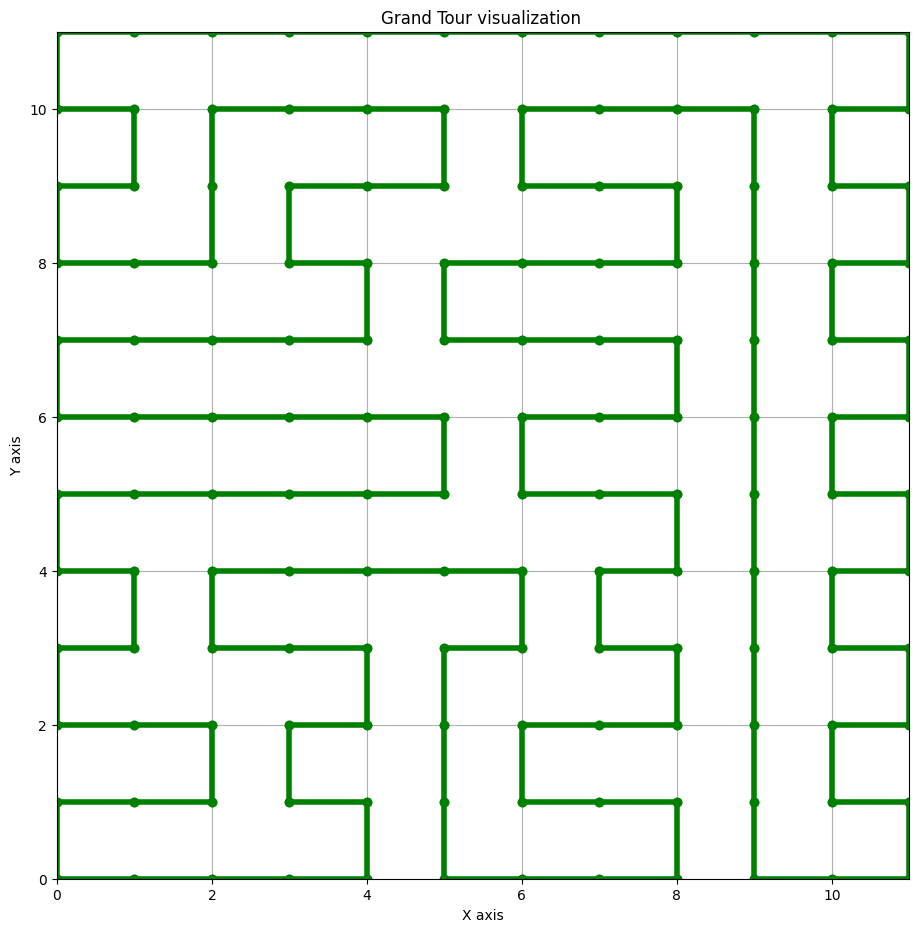

In [25]:
def Vis(m, n, result):
    plt.figure(figsize=(m, n))
    for route in result['arcs']:
        
        begin, end = route[0], route[1]
        route_x, route_y = [], []
        route_x.append(begin % (n + 1))
        route_y.append(m - begin // (n + 1))
        
        route_x.append(end % (n + 1))
        route_y.append(m - end // (n + 1))
        # print(begin, end)

        plt.plot(route_x, route_y, 'go-', label='line 1', linewidth=4)


    plt.xlim(0, m)
    plt.ylim(0, n)

    plt.title(f'Grand Tour visualization ')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    # 显示网格（可选）
    plt.grid(True)
    # 显示图形
    plt.show()

Vis(m, n, result)